In [17]:
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt

## convert results nested folders into dict, and then to df

In [18]:
session_folders = [
    "20241130_215116",
    "20241201_122453",
    "20241220_234554",
    "20250129_155701",
    "20250312_005238",
    "20250312_165021",
]
allres = {}
for session_folder in session_folders:
    session_res = {}
    for root, dirs, files in os.walk(f"output\\{session_folder}"):
        for target_dir in dirs:
            if re.match(r"path_[0-9]{3}", target_dir):
                path = f"{root}\\{target_dir}"
                with open(f"{path}\\evaluation_results.json") as f:
                    results = json.load(f)
                with open(f"{path}\\run_config.json") as f:
                    config = json.load(f)
                parts = path.split("\\")
                if parts[2] not in session_res:
                    session_res[parts[2]] = {}
                session_res[parts[2]][parts[3]] = {**results, **config}
    allres[session_folder] = session_res


with open("allres.json", "w") as f:
    json.dump(allres, f)

allres

{'20241130_215116': {'run_001': {'path_001': {'functional_variance': [0.028986440594983866,
     0.029062914303799234,
     0.02774456124068927,
     0.02676997042387519,
     0.028627678625246133,
     0.027893549525536816,
     0.027641624201294557,
     0.023501803464332546,
     0.028585167284410056,
     0.028128310473661072,
     0.026896045556803565,
     0.026871965097330554,
     0.026245076372084602,
     0.027931858434050754,
     0.02491795782530176,
     0.025159168399916984,
     0.027409360615497216,
     0.030307763315600242,
     0.027433849141838277,
     0.030309629372717972,
     0.028504983309628456,
     0.026761893441488726,
     0.02385241562198127,
     0.02134658969022153,
     0.023310672906557656,
     0.023781050777794157,
     0.02410539951109189,
     0.02544598424835238,
     0.02587926615713571,
     0.02553170400615302,
     0.026983706716082162,
     0.023467236899878712,
     0.022833177724895765,
     0.02621653963317987,
     0.02660624314856609,
 

In [19]:
# convert dict to df, with columns run, path, and phylo_diversity_novelty_index columns

df = pd.DataFrame.from_dict(
    {
        (i, j, k): allres[i][j][k]
        for i in allres.keys()
        for j in allres[i].keys()
        for k in allres[i][j].keys()
    },
    orient="index",
)

df["root_contribution_index"] = df["phylo_diversity_novelty_index"].apply(
    lambda x: x["root_contribution_index"]
)
df["mean_pairwise_distance"] = df["phylo_diversity_novelty_index"].apply(
    lambda x: x["mean_pairwise_distance"]
)
df["phylo_diversity_novelty_index"] = df["phylo_diversity_novelty_index"].apply(
    lambda x: x["phylo_diversity_novelty_index"]
)

df["categorical_diversity"] = df["categorical_diversity_novelty_index"].apply(
    lambda x: x["categorical_diversity"]
)
df["category_change_rate"] = df["categorical_diversity_novelty_index"].apply(
    lambda x: x["category_change_rate"]
)
df["categorical_diversity_novelty_index"] = df[
    "categorical_diversity_novelty_index"
].apply(lambda x: x["categorical_diversity_novelty_index"])
df["dataset_coverage"] = df["dataset_coverage"].mul(100)
df["category_change_rate"] = df["category_change_rate"].apply(
    lambda x: [np.nan if i is None else float(i) for i in x]
)
df["categorical_diversity_novelty_index"] = df[
    "categorical_diversity_novelty_index"
].apply(lambda x: np.nan if x is None else float(x))

In [20]:
list_cols_to_convert = [
    "phylo_diversity_novelty_index",
    "categorical_diversity_novelty_index",
    "category_change_rate",
    "dataset_coverage",
    "category_coverage",
    "root_contribution_index",
    "mean_pairwise_distance",
    "crossover_rate",
    "population_size",
]

for col in list_cols_to_convert:
    print(col)
    print(df[col].dtype)
    # input()

phylo_diversity_novelty_index
float64
categorical_diversity_novelty_index
float64
category_change_rate
object
dataset_coverage
float64
category_coverage
float64
root_contribution_index
float64
mean_pairwise_distance
float64
crossover_rate
float64
population_size
int64


In [21]:
df.to_csv(f"output_adhoc/allres.csv")

## agg

In [22]:
df = pd.read_csv("output_adhoc/allres.csv", index_col=[0, 1, 2])
df["category_change_rate"] = df["category_change_rate"].apply(
    lambda x: [float(i) for i in x.strip("[]").split(", ")]
)
df["functional_variance"] = df["functional_variance"].apply(
    lambda x: [float(i) for i in x.strip("[]").split(", ")]
)
df["categorical_diversity"] = df["categorical_diversity"].apply(
    lambda x: [float(i) for i in x.strip("[]").split(", ")]
)


def mean_of_lists(series):
    return np.nanmean(np.vstack(series), axis=0)


agg_map = {
    "functional_variance": mean_of_lists,
    "phylo_diversity_novelty_index": "mean",
    "categorical_diversity_novelty_index": "mean",
    "category_change_rate": mean_of_lists,
    "dataset_coverage": "mean",
    "category_coverage": "mean",
    "root_contribution_index": "mean",
    "mean_pairwise_distance": "mean",
    "crossover_rate": "first",
    "population_size": "first",
    "projection_method": "first",
    "categorical_diversity": mean_of_lists,
}


df_plot = df.groupby(level=[0, 1]).agg(agg_map)


df_plot

C:\Users\memis\AppData\Local\Temp\ipykernel_20336\4213396511.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.vstack(series), axis=0)


functional_variance  \
20241130_215116 run_001  [0.027074333956835644, 0.027599195889208443, 0...   
                run_002  [0.028265314321219696, 0.0264664885053724, 0.0...   
                run_003  [0.029560763141945993, 0.029510714588291492, 0...   
                run_004  [0.028824066049797405, 0.02813723173095037, 0....   
                run_005  [0.02649916938730998, 0.026543956756621318, 0....   
                run_006  [0.0270984034654157, 0.024983614117490695, 0.0...   
                run_007  [0.02969350934811481, 0.029347243834465235, 0....   
                run_008  [0.029153514915998956, 0.029328192640274354, 0...   
20241201_122453 run_001  [0.026739748965918013, 0.027109047055355762, 0...   
                run_002  [0.026160041590405303, 0.02502799917682621, 0....   
                run_003  [0.02947425112086034, 0.02922259265751671, 0.0...   
                run_004  [0.027853285695977715, 0.028553336353191343, 0...   
20241220_234554 run_001  [0.026409522234042436, 0.02517916445174013, 0....   
                run_002  [0.02873219979489177, 0.0282640641065098, 0.02...   
                run_003  [0.027633424139351555, 0.026274273310529006, 0...   
                run_004  [0.029326531624041398, 0.030387680653132697, 0...   
20250129_155701 run_001  [0.026449029710673568, 0.02366768300719437, 0....   
                run_002  [0.029967272092808483, 0.029524803007049866, 0...   
20250312_005238 run_001  [0.028835641942158662, 0.02896074452416189, 0....   
                run_002  [0.028346639325319965, 0.02869934444338293, 0....   
                run_003  [0.0278853480524859, 0.027525650378885835, 0.0...   
20250312_165021 run_001  [0.025841041023238503, 0.023621064118264742, 0...   
                run_002  [0.027496632199358412, 0.02467989054985654, 0....   
                run_003  [0.027952484730535566, 0.02588217112497279, 0....   

                         phylo_diversity_novelty_index  \
20241130_215116 run_001                       0.670062   
                run_002                       9.219697   
                run_003                      18.910404   
                run_004                      10.911542   
                run_005                       0.798663   
                run_006                       9.079912   
                run_007                      15.981404   
                run_008                      10.364954   
20241201_122453 run_001                       0.674267   
                run_002                       9.350911   
                run_003                      18.879990   
                run_004                      10.926672   
20241220_234554 run_001                       2.238349   
                run_002                      18.389262   
                run_003                       2.103239   
                run_004                      16.457559   
20250129_155701 run_001                       2.551733   
                run_002                      17.486268   
20250312_005238 run_001                      14.652516   
                run_002                       3.503414   
                run_003                       0.645286   
20250312_165021 run_001                      10.222213   
                run_002                       9.790240   
                run_003                       9.243502   

                         categorical_diversity_novelty_index  \
20241130_215116 run_001                                  NaN   
                run_002                                  NaN   
                run_003                                  NaN   
                run_004                                  NaN   
                run_005                                  NaN   
                run_006                                  NaN   
                run_007                                  NaN   
                run_008                                  NaN   
20241201_122453 run_001                                  NaN   
             

## plot metrics

### plot final metrics

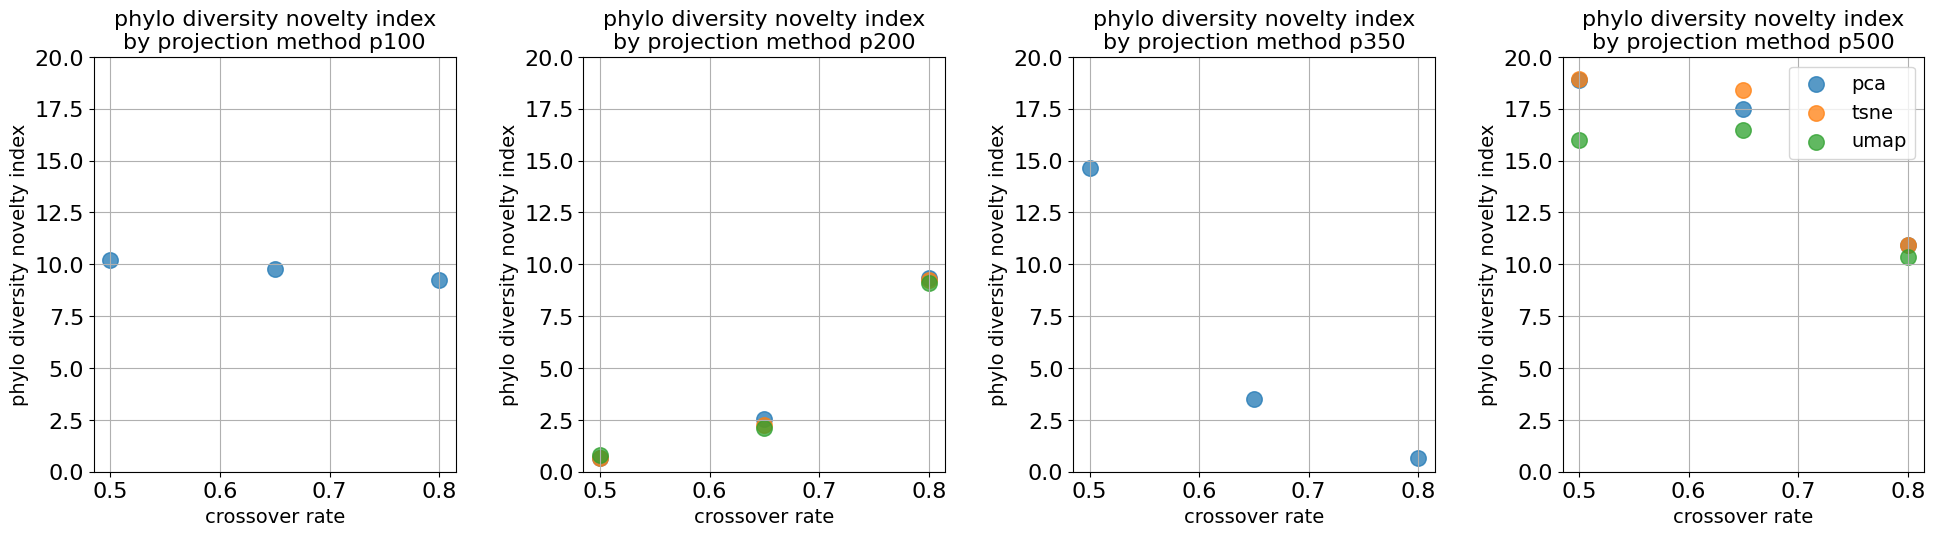

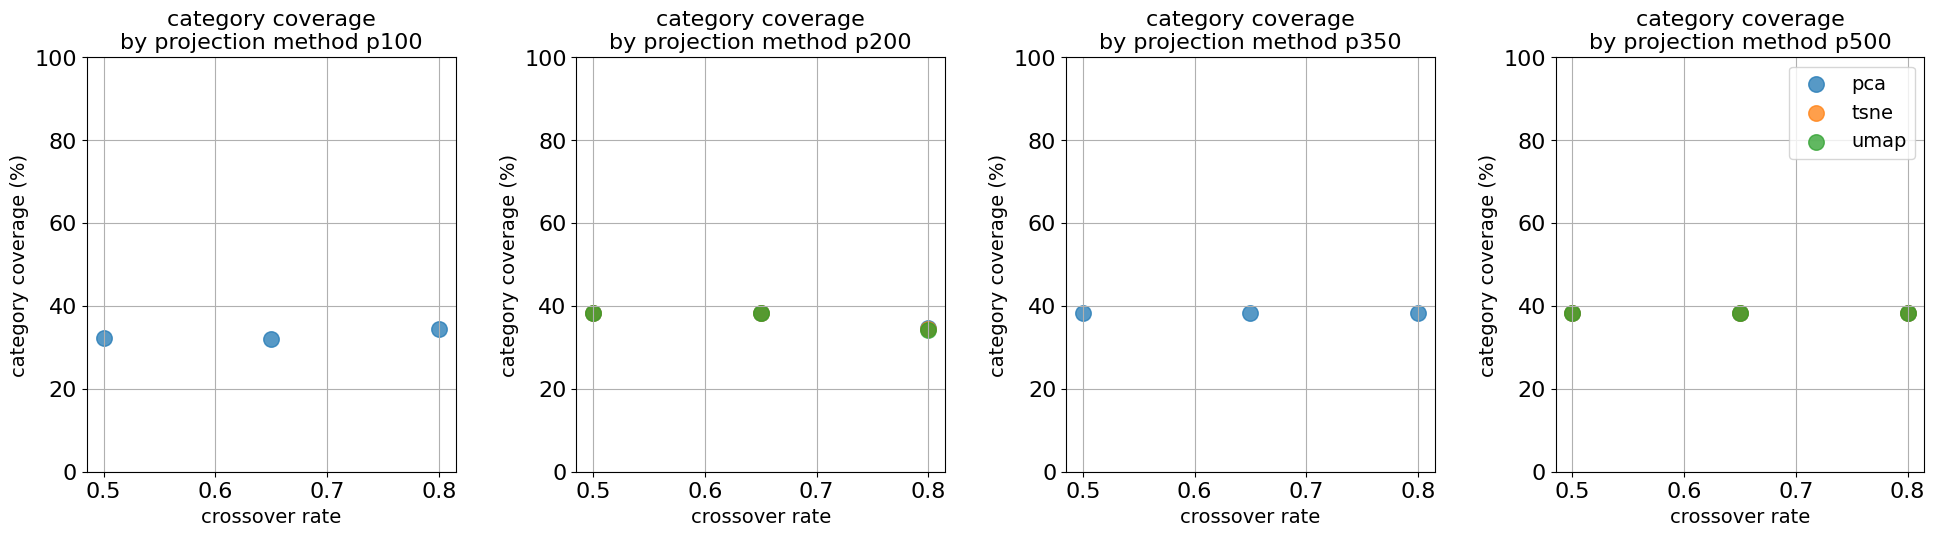

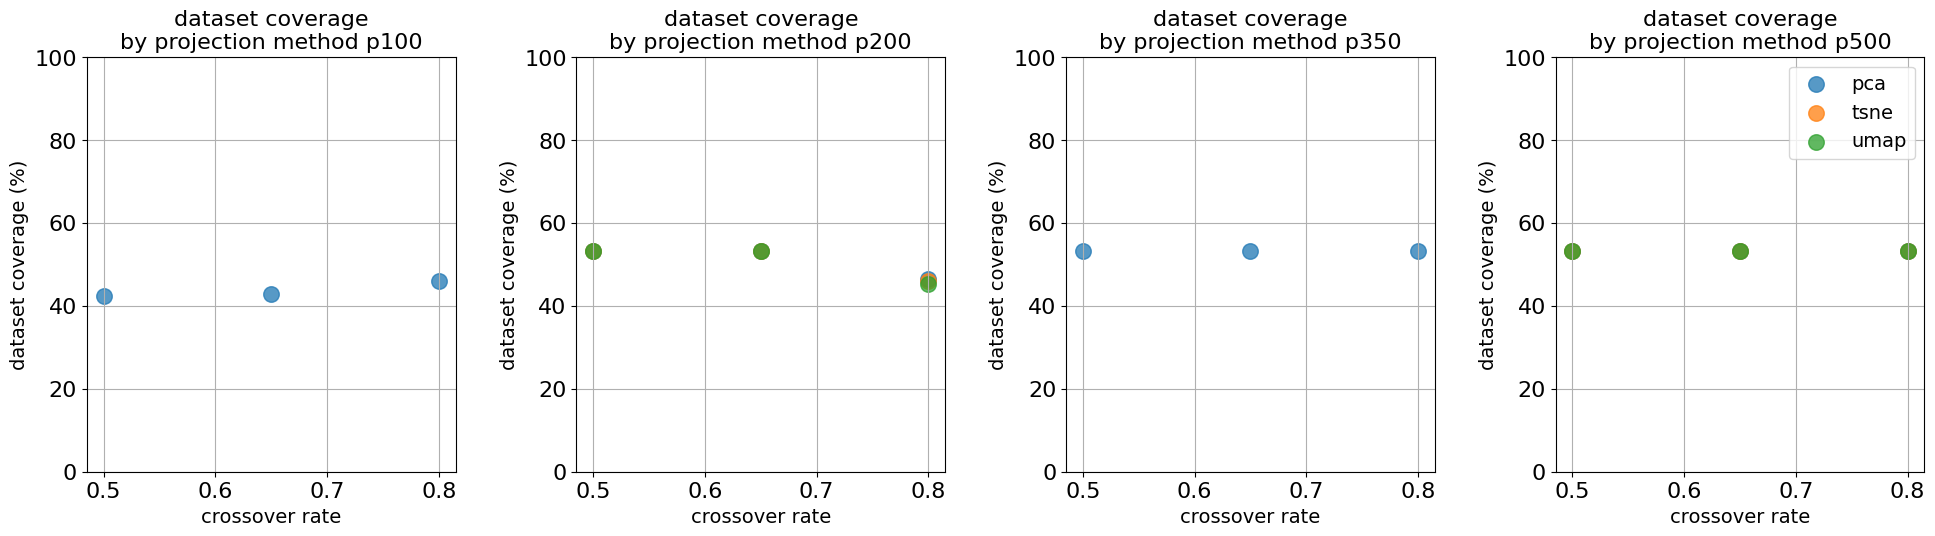

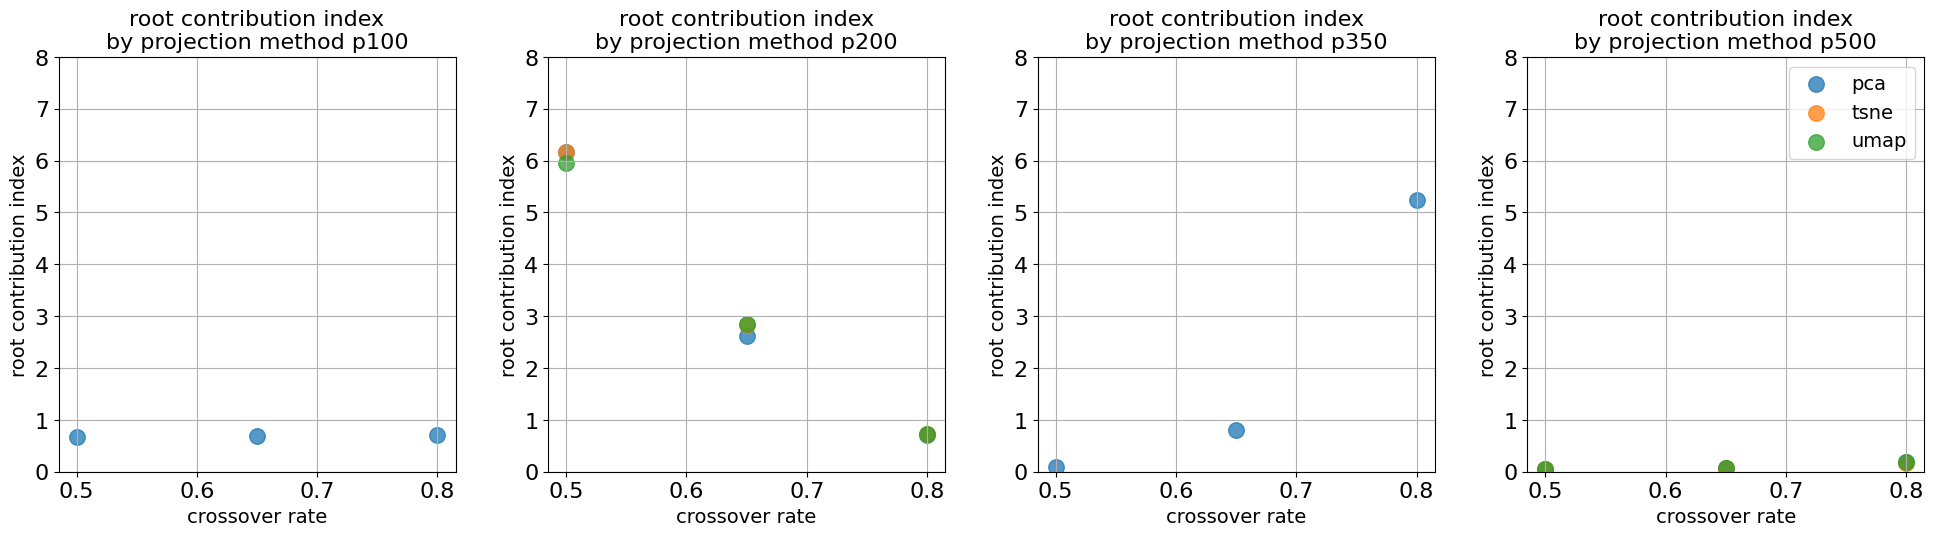

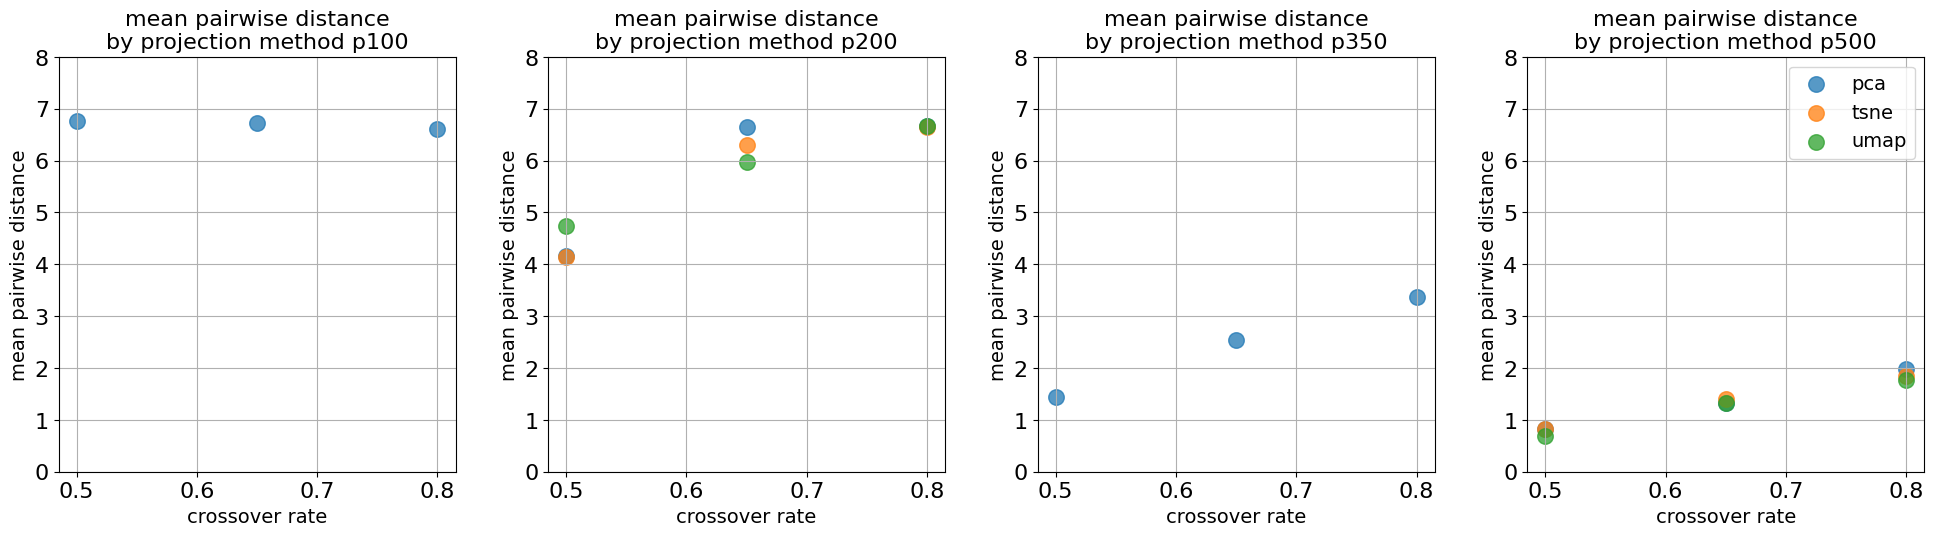

In [29]:
# plot for each popsize
popsize = 100
popsize = 200
popsize = 350
popsize = 500
popsizes = [100, 200, 350, 500]

# metric
metric = "phylo_diversity_novelty_index"
metric = "category_coverage"
metric = "dataset_coverage"
metric = "category_change_rate"
metric = "functional_variance"
metrics = [
    "phylo_diversity_novelty_index",
    # "categorical_diversity_novelty_index",
    "category_coverage",
    "dataset_coverage",
    # "category_change_rate",
    "root_contribution_index",
    "mean_pairwise_distance",
    # "functional_variance",
]

# crossover rate
crossover_rate = 0.5
crossover_rate = 0.65
crossover_rate = 0.8
corates = [0.5, 0.65, 0.8]

metric_lim_map = {
    "phylo_diversity_novelty_index": (0, 20),
    "category_coverage": (0, 100),
    "dataset_coverage": (0, 100),
    "root_contribution_index": (0, 8),
    "mean_pairwise_distance": (0, 8),
}
metric_y_suffix_map = {
    "phylo_diversity_novelty_index": "",
    "category_coverage": " (%)",
    "dataset_coverage": " (%)",
    "root_contribution_index": "",
    "mean_pairwise_distance": "",
}

colors = {"pca": "red", "tsne": "blue", "umap": "green"}

for metric in metrics:
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    for i, popsize in enumerate(popsizes):
        # for crossover_rate in corates:

        df_plot_sub = df_plot[
            [
                "phylo_diversity_novelty_index",
                "categorical_diversity_novelty_index",
                "category_change_rate",
                "dataset_coverage",
                "category_coverage",
                "root_contribution_index",
                "mean_pairwise_distance",
                "crossover_rate",
                "population_size",
                "projection_method",
            ]
        ].copy()

        df_plot_sub = df_plot_sub[df_plot_sub["population_size"] == popsize]

        # scatter plot x-axis as the crossover rate, y-axis as the metric
        # and color by the projection method

        # fig, ax = plt.subplots(figsize=(6, 4))

        for proj_i, group in df_plot_sub.groupby("projection_method"):
            axs[i].scatter(
                group["crossover_rate"],
                group[metric],
                label=proj_i,
                alpha=0.75,
                s=125,
            )

        # axs[i].set_xticks(sorted(df_plot_sub["crossover_rate"].unique()))

        # Ensure the data is sorted by crossover_rate before plotting
        df_plot_sub = df_plot_sub.sort_values(by="crossover_rate")
        # axs[i].set_xticks(sorted(df_plot_sub["crossover_rate"].unique()))
        # axs[i].set_xticklabels(
        #     [str(x) for x in sorted(df_plot_sub["crossover_rate"].unique())]
        # )

        axs[i].set_xlabel("crossover rate", fontsize=14)
        axs[i].set_ylabel(
            metric.replace("_", " ") + metric_y_suffix_map[metric], fontsize=14
        )
        axs[i].set_title(
            f"{metric.replace('_', ' ')}\nby projection method p{popsize}",
            fontsize=16,
        )
        axs[i].set_ylim(*metric_lim_map[metric])
        axs[i].tick_params(axis="both", which="major", labelsize=16)
        axs[i].grid()

    plt.legend(fontsize=14)
    plt.tight_layout(pad=3.0)
    plt.savefig(f"output_adhoc/{metric}.png")
    plt.show()

### plot array metrics

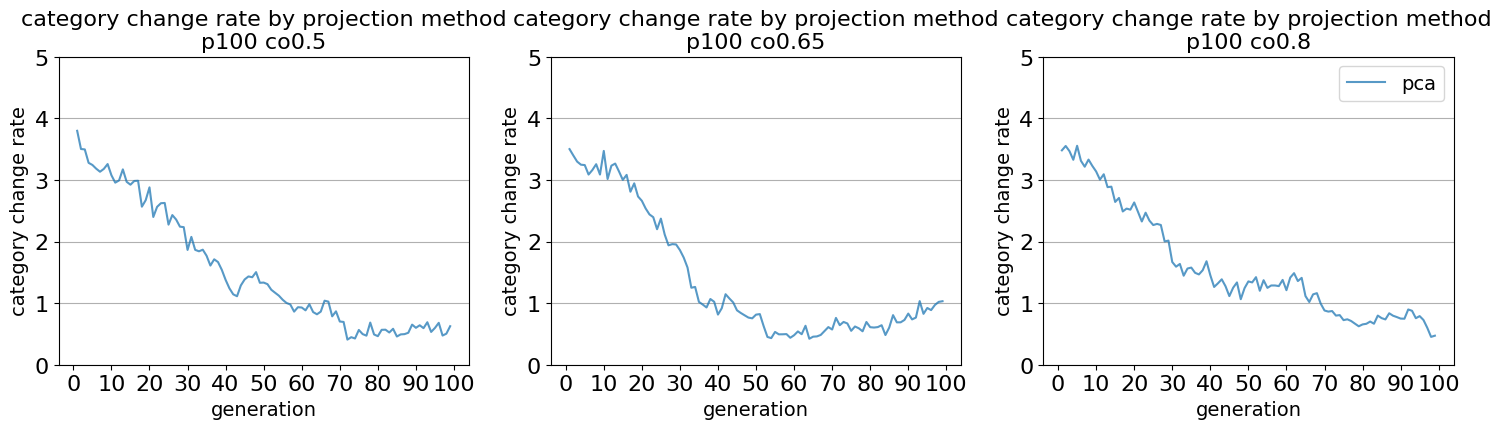

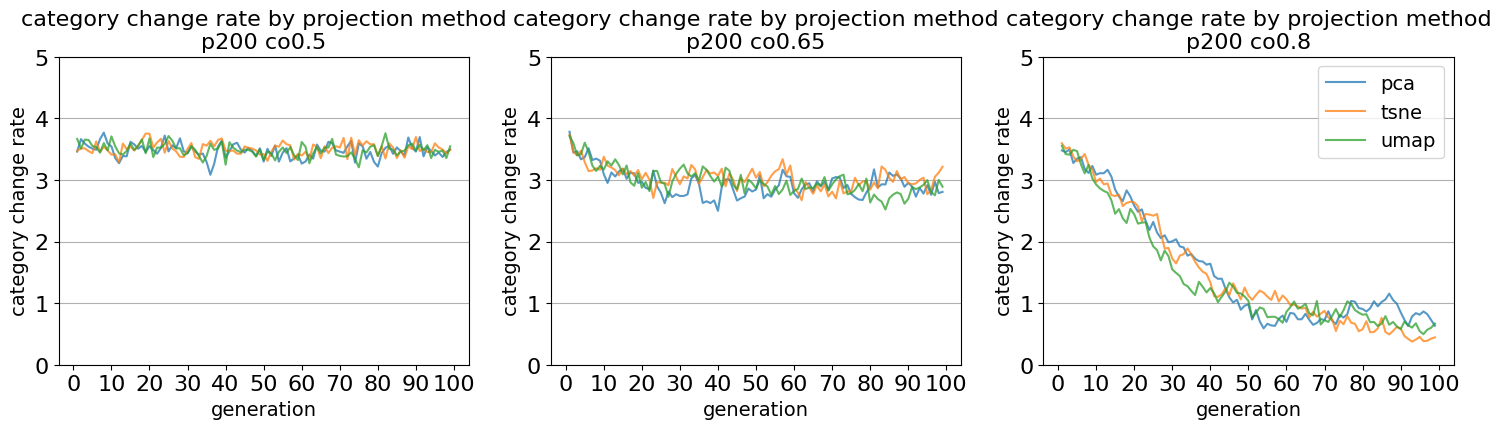

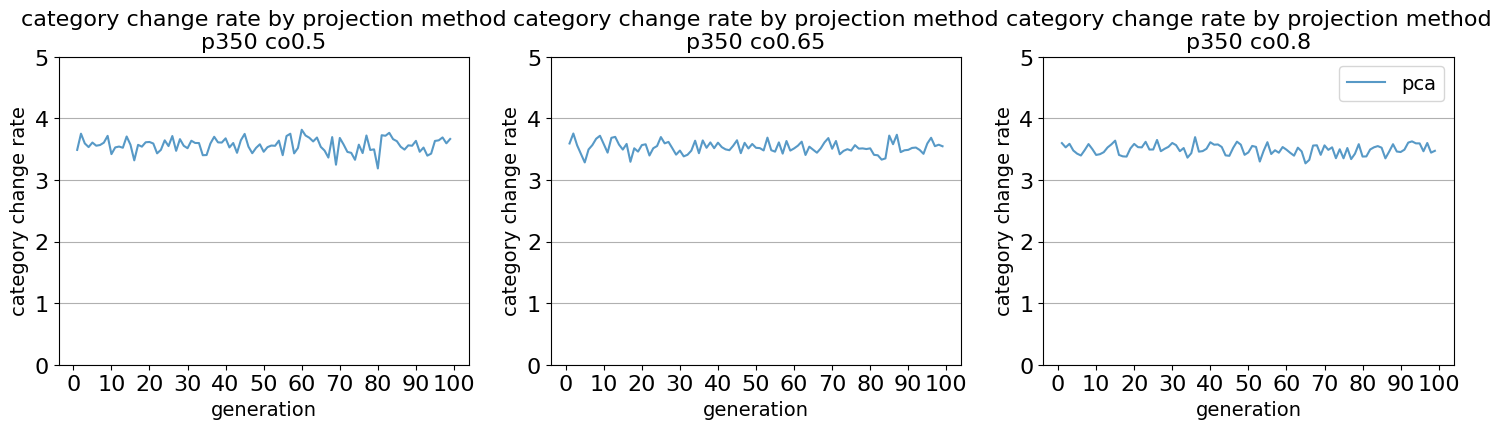

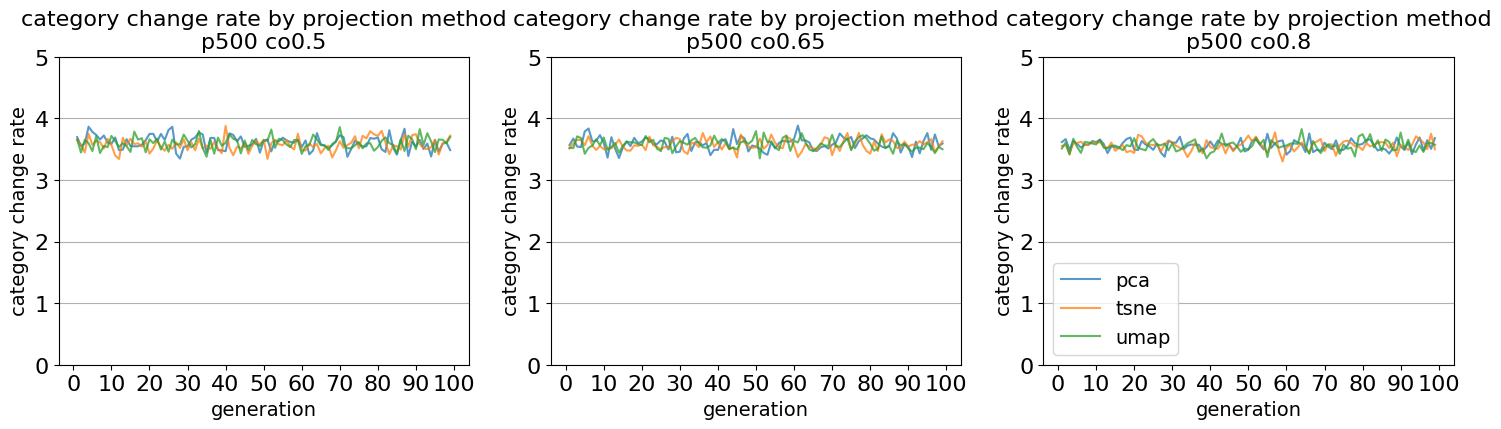

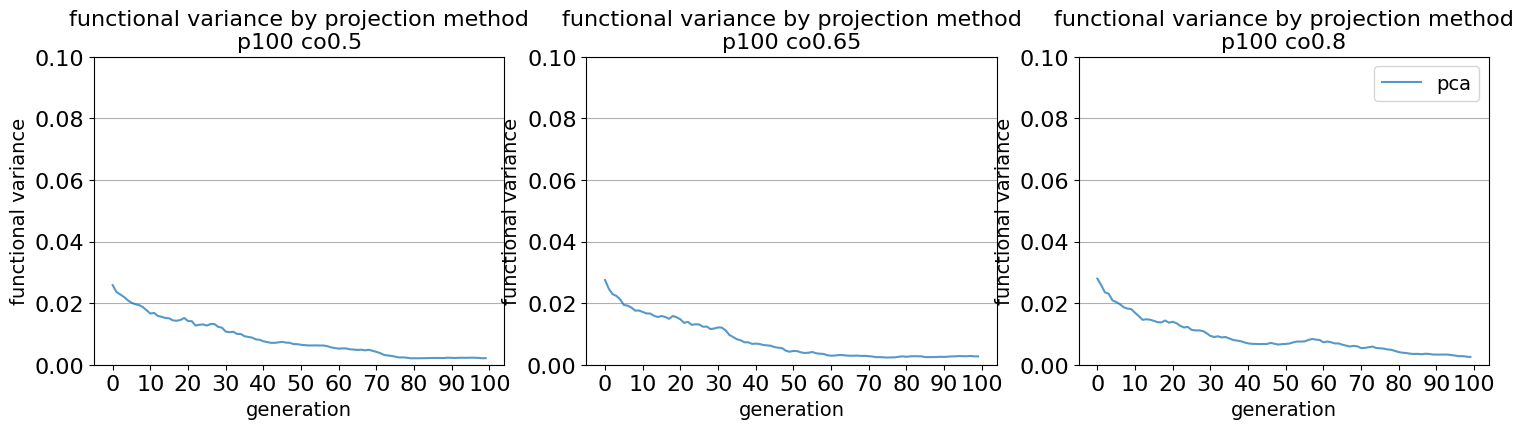

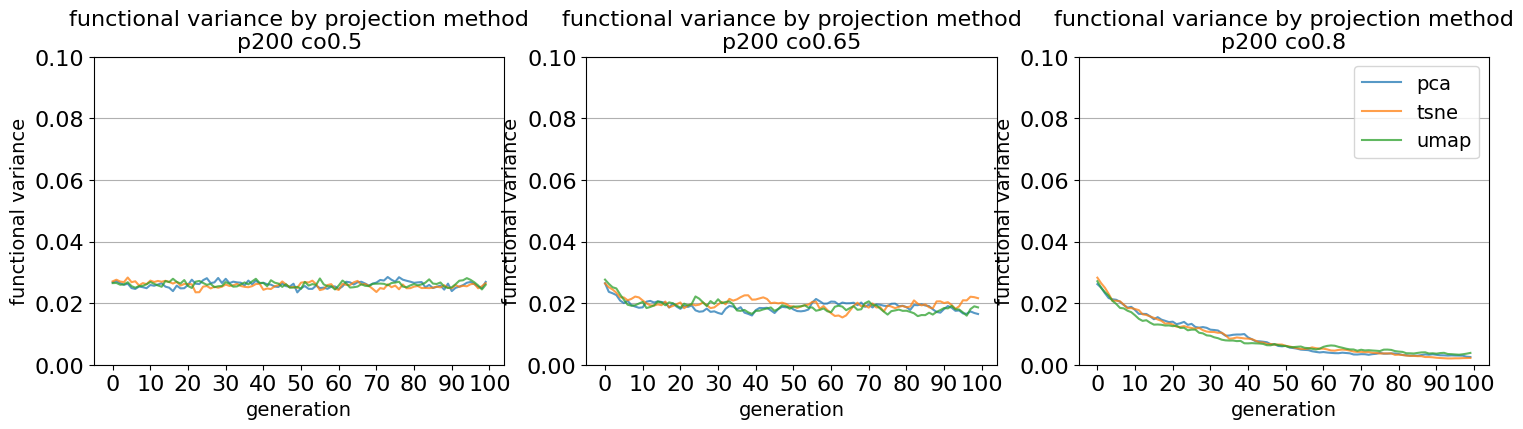

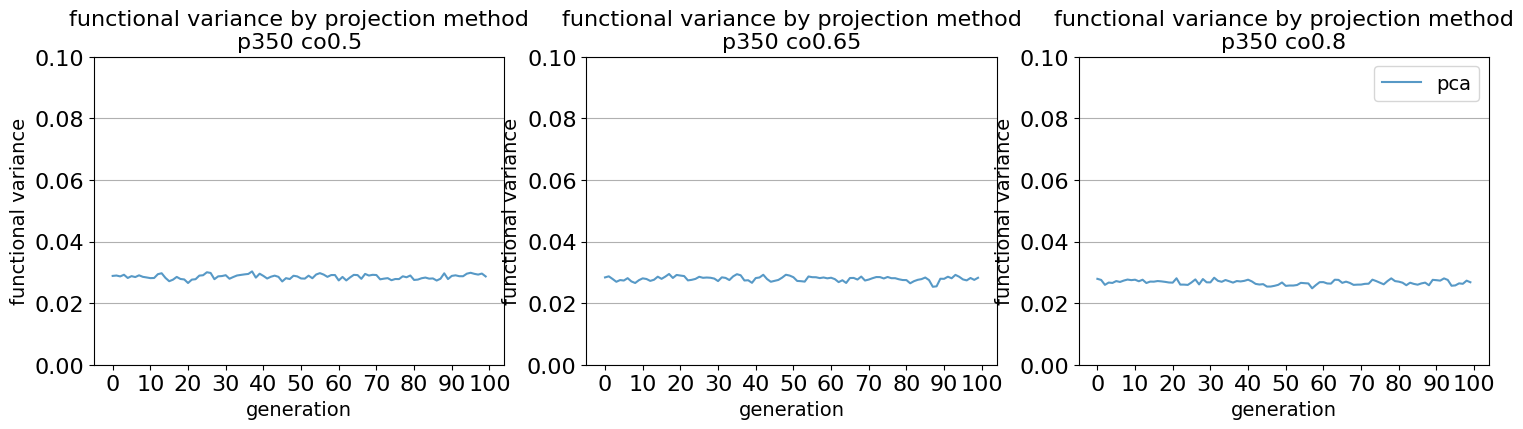

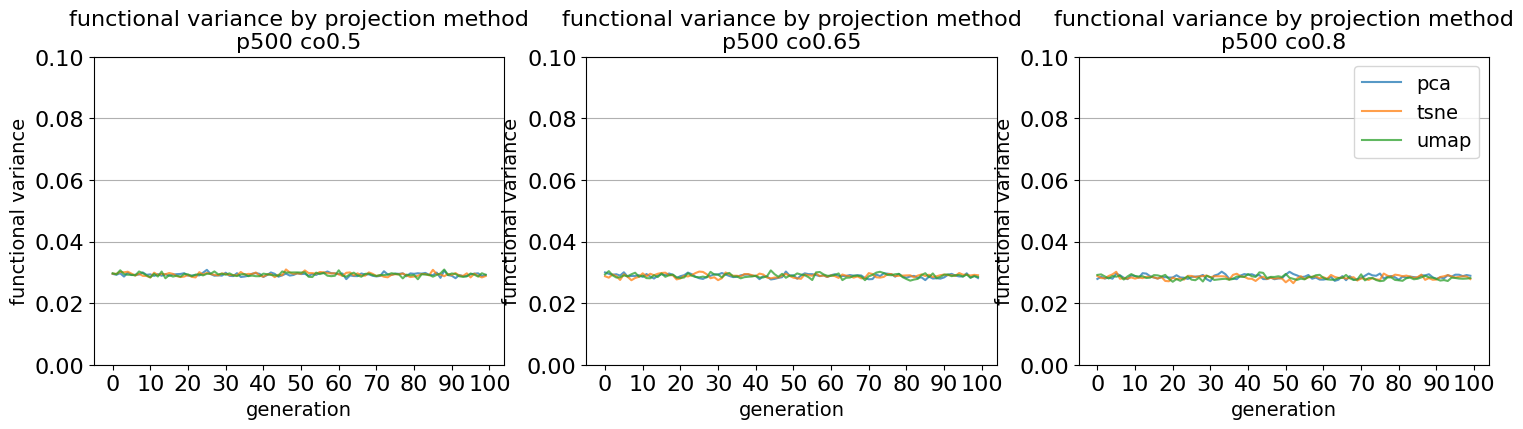

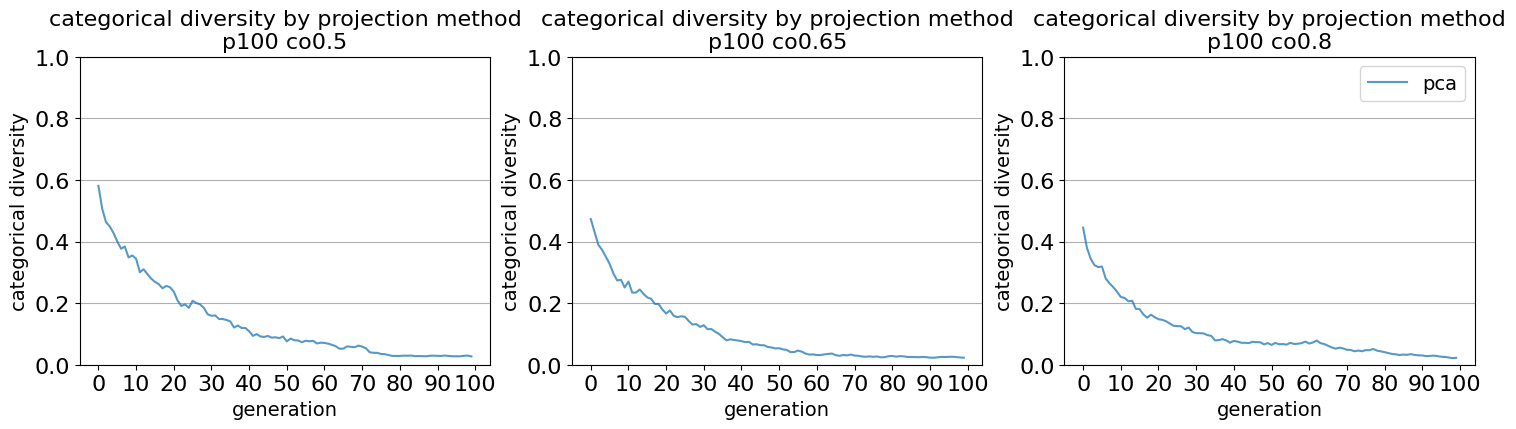

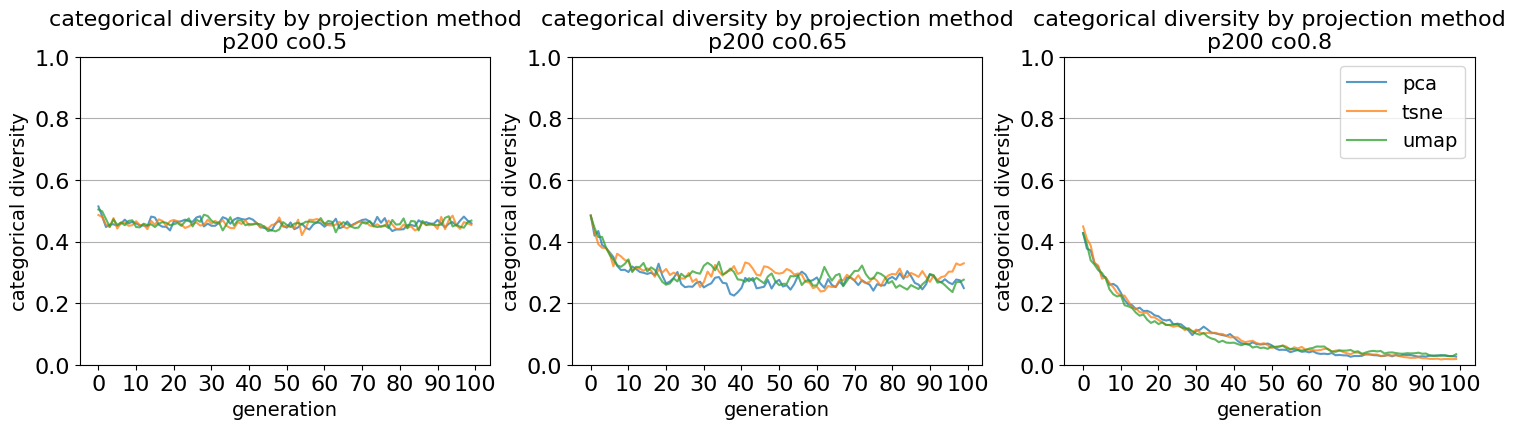

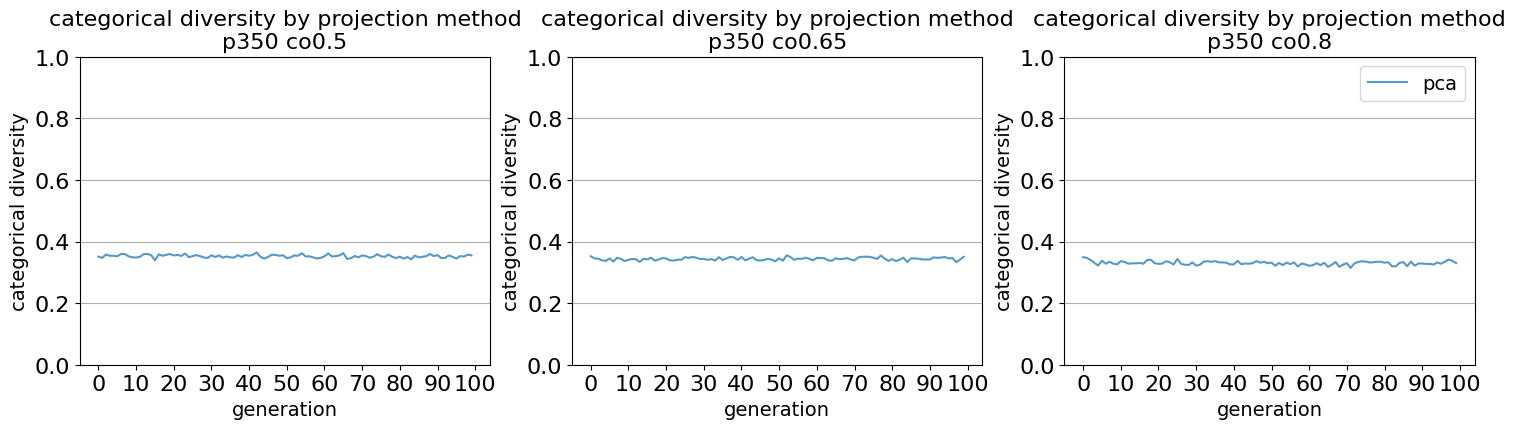

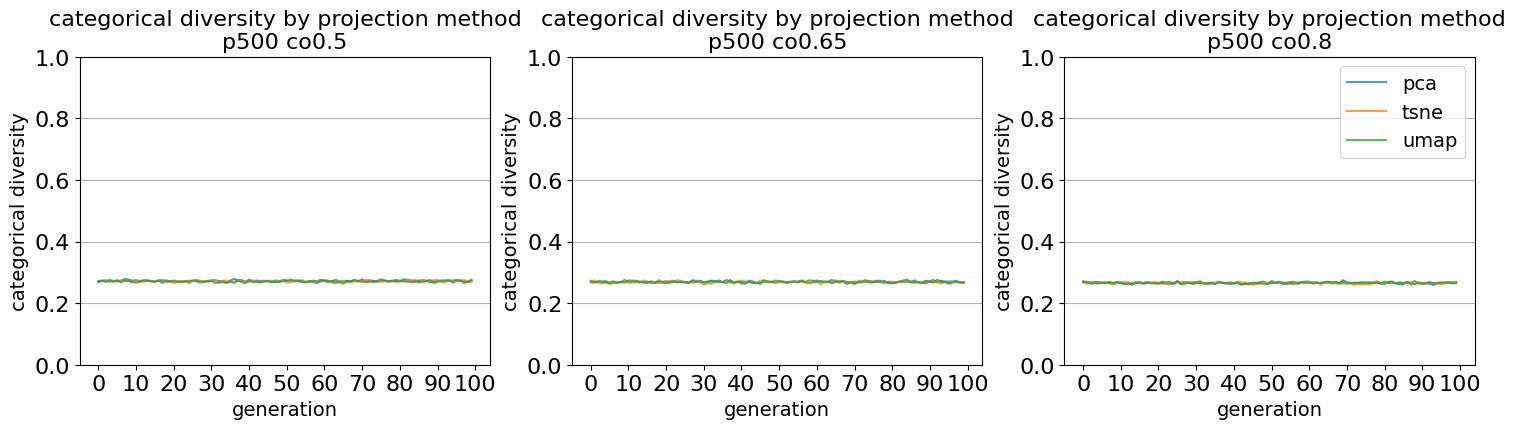

In [28]:
# plot a scatter plot, x axis being the runs, ie index level 1, and y axis
# being the amount. plot projection_method as color

# one plot for each popsize
popsize = 100
popsize = 200
popsize = 350
popsize = 500
popsizes = [100, 200, 350, 500]

# metric
metric = "phylo_diversity_novelty_index"
metric = "category_coverage"
metric = "dataset_coverage"
metric = "category_change_rate"
metric = "functional_variance"
metrics = [
    # "phylo_diversity_novelty_index",
    # "categorical_diversity_novelty_index",
    # "category_coverage",
    # "dataset_coverage",
    "category_change_rate",
    # "root_contribution_index",
    # "mean_pairwise_distance",
    "functional_variance",
    "categorical_diversity",
]
metric_lim_map = {
    "category_coverage": (0, 100),
    "dataset_coverage": (0, 100),
    "category_change_rate": (0, 5),
    "functional_variance": (0, 0.1),
    "categorical_diversity": (0, 1),
}
metric_y_suffix_map = {
    "category_coverage": " (%)",
    "dataset_coverage": " (%)",
    "category_change_rate": "",
    "functional_variance": "",
    "categorical_diversity": "",
}

# crossover rate
crossover_rate = 0.5
crossover_rate = 0.65
crossover_rate = 0.8
corates = [0.5, 0.65, 0.8]

colors = {"pca": "red", "tsne": "blue", "umap": "green"}

for metric in metrics:
    for popsize in popsizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        for i, crossover_rate in enumerate(corates):
            df_plot_sub = df_plot[
                [
                    "phylo_diversity_novelty_index",
                    "categorical_diversity_novelty_index",
                    "category_change_rate",
                    "dataset_coverage",
                    "category_coverage",
                    "root_contribution_index",
                    "mean_pairwise_distance",
                    "crossover_rate",
                    "population_size",
                    "projection_method",
                    "functional_variance",
                    "categorical_diversity",
                ]
            ].copy()
            df_plot_sub = df_plot_sub[df_plot_sub["population_size"] == popsize]
            df_plot_sub = df_plot_sub[
                df_plot_sub["crossover_rate"] == crossover_rate
            ]

            # fig, ax = plt.subplots(figsize=(6, 4))
            for proj_i, group in df_plot_sub.groupby("projection_method"):
                axs[i].plot(
                    group[metric].iloc[0],
                    label=proj_i,
                    # color=colors[i],
                    alpha=0.75,
                )
            # axs[i].legend()
            axs[i].set_xlabel("generation", fontsize=14)
            axs[i].set_ylabel(
                metric.replace("_", " ") + metric_y_suffix_map[metric],
                fontsize=14,
            )
            axs[i].set_title(
                f"{metric.replace('_', ' ')} by projection method\n"
                f"p{popsize} co{crossover_rate}",
                fontsize=16,
            )
            axs[i].set_ylim(*metric_lim_map[metric])
            axs[i].set_xticks(np.arange(0, 101, 10))
            axs[i].tick_params(axis="both", which="major", labelsize=16)
            # add horizontal grid
            axs[i].grid(axis="y")
        plt.legend(fontsize=14)
        plt.savefig(f"output_adhoc/{metric}_p{popsize}.png")
        plt.show()